<a id="top"></a>
#### QCT. Master Thesis - Quantum Computing in Electronics Design

# Quantum Annealing - Linear Equation System Solver

#### Author:
- Javier Parra Paredes, javier.pparedes@alumnos.upm.es

#### Advisor:
- Rafael Martín-Cuevas Redondo, rafamartinc@pm.me

***

In this notebook, we will explore how to solve the unknown variables of a circuit used as a simple example and find its solution using the solvers provided by D-Wave Systems (SimulatedAnnealingSampler from neal package)

### Table of Contents

1. [Shaping the QUBO Model](#qubo_model)
2. [Results](#results)
2. [Finding the solution with D-Wave's solvers](#solution_dwave)
3. [D-Wave´s result postprocessing](#postprocess_dwave)

***

Please run the following block to import the libraries that will be required during the execution of this notebook. If your system lacks any of the libraries mentioned, use ```pip install -r requirements.txt``` in a command line, within this notebook's folder, to ensure that all required libraries are installed.

In [1]:
from sympy import Symbol, Integer, Pow, symbols, expand
from matplotlib import pyplot
import numpy as np
import random, math
import copy
from qubo_formulation import qubo_formulation

from dwave.samplers import SimulatedAnnealingSampler

[Back to the top](#top)

***
<a id="qubo"></a>

## 1. Shaping the QUBO Model

The QUBO formulation of the problem is based on the following papers:

#### Reference : QUBO formulations for numerical quantum computing. 
* Author: Kyungtaek Juna,
* Research Center, Innovative Quantum Computed Tomography, Seoul, Republic of Korea
* ktfriends@gmail.com
* https://arxiv.org/abs/2106.10819

#### Reference : Analyzing the Quantum Annealing Approach for Solving Linear Least Squares Problems
* Authors: Ajinkya Borle and Samuel J. Lomonaco
* CSEE Department,University of Maryland Baltimore County, Baltimore MD 21250
* aborle1@umbc.edu, lomonaco@umbc.edu
* https://arxiv.org/abs/1809.07649

## Example 1: Circuit with 2 nodes and voltage source / resistors (Integer solutions)
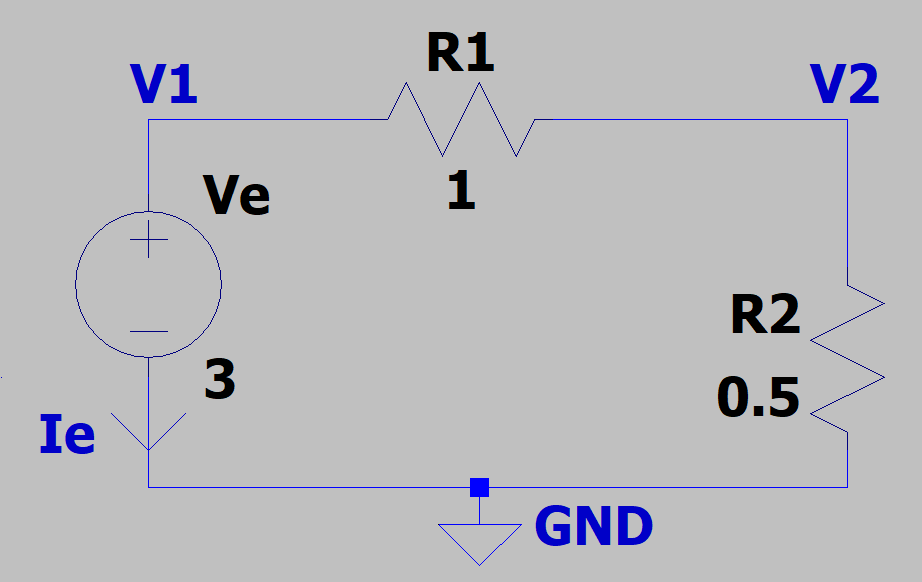


Voltage Source: $V_{e} = 3V$, $R_{1}= 1 \mathsf{\Omega}$, $R_{2}= 0.5 \mathsf{\Omega}$.

Note: For Nodal analysis equations, resistances shall be converted to transconductance : $$g_{1}=1/R_{1}=1 (S) $$, $$g_{2}=1/R_{2}= 2 (S)$$


$$\left [ \begin{matrix} g_{1} & -g_{1} & 1 \\ -g_{1} & g_{1}+g_{2} & 0 \\ 1 & 0 & 0 \end{matrix} \right ] \left [ \begin{matrix} V_{1} \\ V_{2} \\ I_{e} \end{matrix} \right ] = \left [ \begin{matrix} 0 \\ 0 \\ V_{e} \end{matrix} \right ] $$

$$\left [ \begin{matrix} 1 & -1 & 1 \\ -1 & 3 & 0 \\ 1 & 0 & 0 \end{matrix} \right ] \left [ \begin{matrix} V_{1} \\ V_{2} \\ I_{e} \end{matrix} \right ] = \left [ \begin{matrix} 0 \\ 0 \\ 3 \end{matrix} \right ] $$

Expected solutions:
$$V_{1} = V_{e} = 3V$$
$$V_{2} = 1V$$
$$I_{e} = -2A$$

The expected solutions (V1, V2 and Ie) of this circuit are all integer numbers

## Example 2: Circuit with 2 nodes and voltage source / resistors (Fractional solutions)
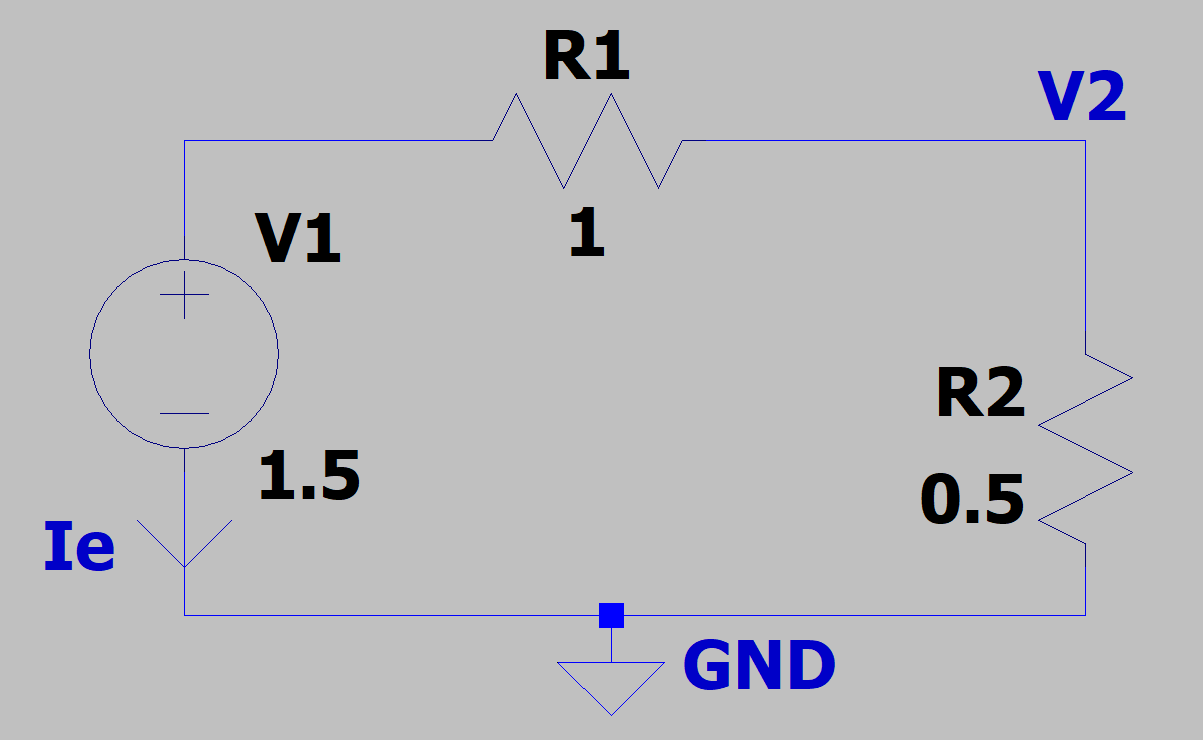

Voltage Source: $V_{e} = 1.5V$, $R_{1}= 1 \mathsf{\Omega}$, $R_{2}= 0.5 \mathsf{\Omega}$.

Note: For Nodal analysis equations, resistances shall be converted to transconductance : $$g_{1}=1/R_{1}=1 (S) $$, $$g_{2}=1/R_{2}= 2 (S)$$


$$\left [ \begin{matrix} g_{1} & -g_{1} & 1 \\ -g_{1} & g_{1}+g_{2} & 0 \\ 1 & 0 & 0 \end{matrix} \right ] \left [ \begin{matrix} V_{1} \\ V_{2} \\ I_{e} \end{matrix} \right ] = \left [ \begin{matrix} 0 \\ 0 \\ V_{e} \end{matrix} \right ] $$

$$\left [ \begin{matrix} 1 & -1 & 1 \\ -1 & 3 & 0 \\ 1 & 0 & 0 \end{matrix} \right ] \left [ \begin{matrix} V_{1} \\ V_{2} \\ I_{e} \end{matrix} \right ] = \left [ \begin{matrix} 0 \\ 0 \\ 1.5 \end{matrix} \right ] $$

Expected solutions:
$$V_{1} = V_{e} = 1.5V$$
$$V_{2} = 0.5V$$
$$I_{e} = -1A$$

The expected solutions (V1, V2) of this circuit are all fractional numbers

[Back to the top](#top)

***
<a id="results"></a>

## 2. Results

There are two approaches, depending on how the variable is built in QUBO model: 
* Approach #1: Same number of qubits for positive and negative values: $x_{i} \approx \sum_{l=-m}^{m} 2^{l}q_{i,l}^{+} - \sum_{l=-m}^{m} 2^{l}q_{i,l}^{-}$
* Approach #2: In order to save qubits, one qubit for the sign of the variable (using 2-complement) and the rest for positive values : $x_{i} \approx -2^{m+1}q_{i}^{-} + \sum_{l=-m}^{m} 2^{l}q_{i,l}^{+}$

With both options, fractional numbers can be obtained (l starting at -m)

Below the code has been implemented to have as parameters: 
* the dimension of the linear equation system (in the case of Example 1 and 2, the dimension is 3) 
* the number of qubits used for the integer part and 
* the number of qubits used for the fractional part. 

The values chosen in circuit 1 and 2 are below 4 and above -4 and as first approach, only 2 qubits have been chosen for the integer and 2 for fractional part. The results can be extended to higher values, increasing the number of qubits in integer part or increase the precision, increasing the number of qubits of the fractional part.

* Approach #1 requires 2 * (qubits for integer + qubits for fractional), for each variable
* Approach #2 requires qubits for integer + qubits for fractional + 1 qubit for the sign, for each variable

[Back to the top](#top)

***
<a id="qubo_matrix_approach_1_circuit_1"></a>

### 2.1 Approach 1, circuit 1 - Qubo Matrix


In [2]:
dimension_approach_1_circuit_1 = 3
qubits_int_approach_1_circuit_1 = 2
qubits_dec_approach_1_circuit_1 = 0
A_approach_1_circuit_1 = np.array([[1, -1, 1], [-1, 3, 0], [1, 0, 0]])
b_approach_1_circuit_1 = np.array([0, 0, 3])

QM_approach_1_circuit_1 = qubo_formulation.get_qubo_matrix_approach_1(dimension=dimension_approach_1_circuit_1, 
                                                     qubits_int=qubits_int_approach_1_circuit_1, 
                                                     qubits_dec=qubits_dec_approach_1_circuit_1, 
                                                     A=A_approach_1_circuit_1, 
                                                     b=b_approach_1_circuit_1)

# Matrix Q is
[[ -3.  12.   0.   0.  -8. -16.   8.  16.   2.   4.  -2.  -4.]
 [  0.   0.   0.   0. -16. -32.  16.  32.   4.   8.  -4.  -8.]
 [  0.   0.   9.  12.   8.  16.  -8. -16.  -2.  -4.   2.   4.]
 [  0.   0.   0.  24.  16.  32. -16. -32.  -4.  -8.   4.   8.]
 [  0.   0.   0.   0.  10.  40.   0.   0.  -2.  -4.   2.   4.]
 [  0.   0.   0.   0.   0.  40.   0.   0.  -4.  -8.   4.   8.]
 [  0.   0.   0.   0.   0.   0.  10.  40.   2.   4.  -2.  -4.]
 [  0.   0.   0.   0.   0.   0.   0.  40.   4.   8.  -4.  -8.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   4.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   4.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.]]


[Back to the top](#top)

***
<a id="qubo_matrix_approach_1_circuit_2"></a>

### 2.3 Approach 1, circuit 2- Qubo Matrix


In [3]:
dimension_approach_1_circuit_2 = 3
qubits_int_approach_1_circuit_2 = 2
qubits_dec_approach_1_circuit_2 = 2
A_approach_1_circuit_2 = np.array([[1, -1, 1], [-1, 3, 0], [1, 0, 0]])
b_approach_1_circuit_2 = np.array([0, 0, 1.5])

QM_approach_1_circuit_2 = qubo_formulation.get_qubo_matrix_approach_1(dimension=dimension_approach_1_circuit_2, 
                                                     qubits_int=qubits_int_approach_1_circuit_2, 
                                                     qubits_dec=qubits_dec_approach_1_circuit_2, 
                                                     A=A_approach_1_circuit_2, 
                                                     b=b_approach_1_circuit_2)

# Matrix Q is
[[ -0.5625   0.75     1.5      3.       0.       0.       0.       0.
   -0.5     -1.      -2.      -4.       0.5      1.       2.       4.
    0.125    0.25     0.5      1.      -0.125   -0.25    -0.5     -1.    ]
 [  0.      -0.75     3.       6.       0.       0.       0.       0.
   -1.      -2.      -4.      -8.       1.       2.       4.       8.
    0.25     0.5      1.       2.      -0.25    -0.5     -1.      -2.    ]
 [  0.       0.       0.      12.       0.       0.       0.       0.
   -2.      -4.      -8.     -16.       2.       4.       8.      16.
    0.5      1.       2.       4.      -0.5     -1.      -2.      -4.    ]
 [  0.       0.       0.       6.       0.       0.       0.       0.
   -4.      -8.     -16.     -32.       4.       8.      16.      32.
    1.       2.       4.       8.      -1.      -2.      -4.      -8.    ]
 [  0.       0.       0.       0.       0.9375   0.75     1.5      3.
    0.5      1.       2.       4.      -0.5     -1.     

[Back to the top](#top)

***
<a id="qubo_matrix_approach_2_circuit_1"></a>

### 2.4 Approach 2, circuit 1 - Qubo Matrix


In [5]:
dimension_approach_2_circuit_1 = 3
qubits_int_approach_2_circuit_1 = 2
qubits_dec_approach_2_circuit_1 = 0
A_approach_2_circuit_1 = np.array([[1, -1, 1], [-1, 3, 0], [1, 0, 0]])
b_approach_2_circuit_1 = np.array([0, 0, 3])

QM_approach_2_circuit_1 = qubo_formulation.get_qubo_matrix_approach_2(dimension=dimension_approach_2_circuit_1, 
                                                     qubits_int=qubits_int_approach_2_circuit_1, 
                                                     qubits_dec=qubits_dec_approach_2_circuit_1, 
                                                     A=A_approach_2_circuit_1, 
                                                     b=b_approach_2_circuit_1)

# Matrix Q is
[[  72.  -24.  -48. -128.   32.   64.   32.   -8.  -16.]
 [   0.   -3.   12.   32.   -8.  -16.   -8.    2.    4.]
 [   0.    0.    0.   64.  -16.  -32.  -16.    4.    8.]
 [   0.    0.    0.  160.  -80. -160.  -32.    8.   16.]
 [   0.    0.    0.    0.   10.   40.    8.   -2.   -4.]
 [   0.    0.    0.    0.    0.   40.   16.   -4.   -8.]
 [   0.    0.    0.    0.    0.    0.   16.   -8.  -16.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    4.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    4.]]


[Back to the top](#top)

***
<a id="qubo_matrix_approach_2_circuit_2"></a>

### 2.5 Approach 2, circuit 2 - Qubo Matrix


In [6]:
dimension_approach_2_circuit_2 = 3
qubits_int_approach_2_circuit_2 = 2
qubits_dec_approach_2_circuit_2 = 2
A_approach_2_circuit_2 = np.array([[1, -1, 1], [-1, 3, 0], [1, 0, 0]])
b_approach_2_circuit_2 = np.array([0, 0, 1.5])

QM_approach_2_circuit_2 = qubo_formulation.get_qubo_matrix_approach_2(dimension=dimension_approach_2_circuit_2, 
                                                     qubits_int=qubits_int_approach_2_circuit_2, 
                                                     qubits_dec=qubits_dec_approach_2_circuit_2, 
                                                     A=A_approach_2_circuit_2, 
                                                     b=b_approach_2_circuit_2)

# Matrix Q is
[[ 6.000e+01 -6.000e+00 -1.200e+01 -2.400e+01 -4.800e+01 -1.280e+02
   8.000e+00  1.600e+01  3.200e+01  6.400e+01  3.200e+01 -2.000e+00
  -4.000e+00 -8.000e+00 -1.600e+01]
 [ 0.000e+00 -5.625e-01  7.500e-01  1.500e+00  3.000e+00  8.000e+00
  -5.000e-01 -1.000e+00 -2.000e+00 -4.000e+00 -2.000e+00  1.250e-01
   2.500e-01  5.000e-01  1.000e+00]
 [ 0.000e+00  0.000e+00 -7.500e-01  3.000e+00  6.000e+00  1.600e+01
  -1.000e+00 -2.000e+00 -4.000e+00 -8.000e+00 -4.000e+00  2.500e-01
   5.000e-01  1.000e+00  2.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.200e+01  3.200e+01
  -2.000e+00 -4.000e+00 -8.000e+00 -1.600e+01 -8.000e+00  5.000e-01
   1.000e+00  2.000e+00  4.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  6.000e+00  6.400e+01
  -4.000e+00 -8.000e+00 -1.600e+01 -3.200e+01 -1.600e+01  1.000e+00
   2.000e+00  4.000e+00  8.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.600e+02
  -2.000e+01 -4.000e+01 -8.000e+01 -1.600e+02 -3.200e+01  

[Back to the top](#top)

***
<a id="solution_dwave"></a>

## 3. Finding the solution with D-Wave's solvers

From the Q Matrix, the qubo model can be implemented and solved by Dwave tools

[Back to the top](#top)

***
<a id="dwave_solver_code"></a>

### 3.1 DWave Solver code, Approaches 1 and 2 (Simulator)


In [9]:
# Print Python code for the run in D-Wave quantum processing unit

def get_dwave_solution_approach_1(dimension, qubits_int, qubits_dec, QM):
    
    QM = 1000*QM # All coefficients of QM shall be integer

    linear_dict = {}
    for i in range(2*(qubits_int+qubits_dec)*dimension-1): 
        linear = i + 1
        linear_dict[("q"+ str(linear), "q"+str(linear))] = QM[i][i]

    linear_dict[("q"+ str(2*(qubits_int+qubits_dec)*dimension), "q"+str(2*(qubits_int+qubits_dec)*dimension))] = QM[2*(qubits_int+qubits_dec)*dimension-1][2*(qubits_int+qubits_dec)*dimension-1]  

    # print(linear_dict)

    quadratic_dict = {}

    for i in range(2*(qubits_int+qubits_dec)*dimension-1):
        for j in range(i+1,2*(qubits_int+qubits_dec)*dimension):
            if QM[i][j] != 0:
                qdrt1 = i + 1
                qdrt2 = j + 1
                quadratic_dict[("q"+str(qdrt1), "q"+str(qdrt2))] = QM[i][j]


    # print(quadratic_dict)

    qubo = dict(linear_dict)
    qubo.update(quadratic_dict)

    # print(qubo)

    sampler = SimulatedAnnealingSampler()
    num_reads = 5000

    response = sampler.sample_qubo(qubo, num_reads=num_reads)
    response = response.aggregate()

    print(response)

    for values, _, num_occurrences in response.data():
        variables = [key for key in values if values[key] != 0]
        print('{:4.0f}/{} occurrences: {}'.format(
            num_occurrences, num_reads, variables
        ))

In [10]:
# Print Python code for the run in D-Wave quantum processing unit

def get_dwave_solution_approach_2(dimension, qubits_int, qubits_dec, QM):

    if qubits_dec > 0:
        QM = 1000*QM # All coefficients of QM shall be integer

    linear_dict = {}
    for i in range((qubits_int+qubits_dec+1)*dimension-1): 
        linear = i + 1
        linear_dict[("q"+ str(linear), "q"+str(linear))] = QM[i][i]

    linear_dict[("q"+ str((qubits_int+qubits_dec + 1)*dimension), "q"+str((qubits_int+qubits_dec+1)*dimension))] = QM[(qubits_int+qubits_dec+1)*dimension-1][(qubits_int+qubits_dec+1)*dimension-1]  

    # print(linear_dict)

    quadratic_dict = {}

    for i in range((qubits_int+qubits_dec+1)*dimension-1):
        for j in range(i+1,(qubits_int+qubits_dec+1)*dimension):
            if QM[i][j] != 0:
                qdrt1 = i + 1
                qdrt2 = j + 1
                quadratic_dict[("q"+str(qdrt1), "q"+str(qdrt2))] = QM[i][j]


    # print(quadratic_dict)

    qubo = dict(linear_dict)
    qubo.update(quadratic_dict)

    print(qubo)

    sampler = SimulatedAnnealingSampler()
    num_reads = 10000

    response = sampler.sample_qubo(qubo, num_reads=num_reads)
    response = response.aggregate()

    print(response)

    for values, _, num_occurrences in response.data():
        variables = [key for key in values if values[key] != 0]
        print('{:4.0f}/{} occurrences: {}'.format(
            num_occurrences, num_reads, variables
        ))

[Back to the top](#top)

***
<a id="qubo_matrix_approach_1_circuit_1"></a>

### 3.2 Approach 1, circuit 1 - DWave Solver (Simulator)


In [11]:
get_dwave_solution_approach_1(dimension=dimension_approach_1_circuit_1, qubits_int=qubits_int_approach_1_circuit_1, 
                   qubits_dec=qubits_dec_approach_1_circuit_1, QM=QM_approach_1_circuit_1 )

  q1 q10 q11 q12 q2 q3 q4 q5 q6 q7 q8 q9  energy num_oc.
0  1   0   0   1  1  0  0  1  0  0  0  0 -9000.0    4979
1  1   0   1   0  1  0  0  1  0  0  0  0 -8000.0      11
3  1   0   1   1  1  0  0  1  0  0  0  0 -8000.0       4
2  1   0   1   0  0  0  0  0  0  0  0  0 -4000.0       6
['BINARY', 4 rows, 5000 samples, 12 variables]
4979/5000 occurrences: ['q1', 'q12', 'q2', 'q5']
  11/5000 occurrences: ['q1', 'q11', 'q2', 'q5']
   4/5000 occurrences: ['q1', 'q11', 'q12', 'q2', 'q5']
   6/5000 occurrences: ['q1', 'q11']


[Back to the top](#top)

***
<a id="postprocess_dwave_circuit_1_approach_1"></a>

###  3.3 D-Wave´s result postprocessing - Approach 1, Circuit 1

From the Q Matrix, the qubo model can be implemented and solved by Dwave tools

* $V_{1}$ = [q1, q2, q3, q4], where [q1, q2] corresponds with the positive value (q2 is the MSB) and [q3, q4] corresponds to the negative value (q4 is the MSB)
* $V_{2}$ = [q5, q6, q7, q8], where [q5, q6] corresponds with the positive value (q6 is the MSB) and [q7, q8] corresponds to the negative value. (q8 is the MSB)
* $I_{e}$ = [q9, q10, q11, q12], where [q9, q10] corresponds with the positive value (q10 is the MSB) and [q11, q12] corresponds to the negative value. (q12 is the MSB)

The results obtained from D-Wave solver show that the most likely solution is [q1,q2,q5,q12] (bits set to 1, while the other are 0).

Reconstructing each variable: 
* $V_{1}$ = [q1, q2, q3, q4] = [1, 1 , 0, 0] = 1*2^0 + 1*2^1 - 0*2^(0) - 0*2^(1) = 3V (as expected , $V_{1}$ = $V_{e}$)
* $V_{2}$ = [q5, q6, q7, q8] = [1, 0 , 0, 0] = 1*2^0 + 0*2^1 - 0*2^(0) - 0*2^(1) = 1V (as expected)
* $I_{e}$ = [q9, q10, q11, q12] = [0, 0 , 0, 1] = 0*2^0 + 0*2^1 - 0*2^(0) - 1*2^(1) = -2A (as expected)

[Back to the top](#top)

***
<a id="dwave_solver_approach_2_circuit_1"></a>

### 3.4 Approach 1, circuit 2 - DWave Solver (Simulator)


In [ ]:
get_dwave_solution_approach_1(dimension=dimension_approach_1_circuit_2, qubits_int=qubits_int_approach_1_circuit_2, 
                   qubits_dec=qubits_dec_approach_1_circuit_2, QM=QM_approach_1_circuit_2 )

[Back to the top](#top)

***
<a id="postprocess_dwave_example_1_approach_1"></a>

### 3.5 D-Wave´s result postprocessing - Approach 1, Circuit 2

From the Q Matrix, the qubo model can be implemented and solved by Dwave tools

* $V_{1}$ = [q1, q2, q3, q4, q5, q6, q7, q8], where [q1, q2] corresponds with the positive and fractional, [q3, q4] corresponds with the positive and integer,  [q5, q6] corresponds to the negative and fractional value and [q7, q8] corresponds to the negative and integer value
* $V_{2}$ = [q9, q10, q11, q12, q13, q14, q15, q16], where [q9, q10] corresponds with the positive and fractional, [q11, q12] corresponds with the positive and integer,  [q13, q14] corresponds to the negative and fractional value and [q15, q16] corresponds to the negative and integer value
* $I_{e}$ = [q17, q18, q19, q20, q21, q22, q23, q24], where [q17, q18] corresponds with the positive and fractional, [q19, q20] corresponds with the positive and integer,  [q21, q22] corresponds to the negative and fractional value and [q23, q24] corresponds to the negative and integer value

The results obtained from D-Wave solver show that the most likely solution is ['q10', 'q2', 'q23', 'q3'] (bits set to 1, while the other are 0).

Reconstructing each variable: 
* $V_{1}$ = [q1, q2, q3, q4, q5, q6, q7, q8] = [0, 1 , 1, 0, 0, 0, 0, 0] = 0 * 1/4 + 1 * 1/2 + 1 * 2^0 + 0... = 1.5V (as expected , $V_{1}$ = $V_{e}$)
* $V_{2}$ = [q9, q10, q11, q12, q13, q14, q15, q16] = [0,1,0, 0, 0, 0, 0, 0] 0 * 1/4 + 1 * 1/2 + 0 * 2^0 + 0... = 0.5V (as expected)
* $I_{e}$ = [q17, q18, q19, q20, q21, q22, q23, q24] = [0,0,0, 0, 0, 0, 1, 0] = 0 ... - 1 * 2^0 =  -1A (as expected)

[Back to the top](#top)

***
<a id="dwave_solver_approach_2_circuit_1"></a>

### 3.6 Approach 2, circuit 1 - DWave Solver (Simulator)


In [ ]:
get_dwave_solution_approach_2(dimension=dimension_approach_2_circuit_1, qubits_int=qubits_int_approach_2_circuit_1, 
                   qubits_dec=qubits_dec_approach_2_circuit_1, QM=QM_approach_2_circuit_1 )

[Back to the top](#top)

***
<a id="postprocess_dwave"></a>

### 3.7 D-Wave´s result postprocessing - Approach 2, circuit 1

From the Q Matrix, the qubo model can be implemented and solved by Dwave tools

* $V_{1}$ = [q1, q2, q3], where [q1] corresponds with the sign and [q2,q3] corresponds to the positive value (q3 is the MSB)
* $V_{2}$ = [q4, q5, q6], where [q4] corresponds with the sign and [q5,q6] corresponds to the positive value (q6 is the MSB)
* $I_{e}$ = [q7, q8, q9], where [q7] corresponds with the sign and [q8,q9] corresponds to the positive value (q9 is the MSB)

The results obtained from D-Wave solver show that the most likely solution is [q2,q3,q5,q7,q9] (bits set to 1, while the other are 0).

Reconstructing each variable: 
* $V_{1}$ = [q2, q3] = 0 + 1 + 2 = 3V (as expected , $V_{1}$ = $V_{e}$)
* $V_{2}$ = [q5] = 0 + 1 + 0 = 1V (as expected)
* $I_{e}$ = [q7, q9] = -4 + 0 + 2 = -2A (as expected)


[Back to the top](#top)

***
<a id="dwave_solver_approach_2_circuit_1"></a>

### 3.8 Approach 2, circuit 2 - DWave Solver (Simulator)


In [ ]:
get_dwave_solution_approach_2(dimension=dimension_approach_2_circuit_2, qubits_int=qubits_int_approach_2_circuit_2, 
                   qubits_dec=qubits_dec_approach_2_circuit_2, QM=QM_approach_2_circuit_2 )

[Back to the top](#top)

***
<a id="postprocess_dwave"></a>

### 3.9 D-Wave´s result postprocessing - Approach 2, Circuit 2

From the Q Matrix, the qubo model can be implemented and solved by Dwave tools

* $V_{1}$ = [q1, q2, q3, q4, q5], where [q1] corresponds with the sign and [q2,q3] corresponds to the positive (fractional) value (q3 is the MSB) and [q4,q5] corresponds to the positive (integer) value
* $V_{2}$ = [q6, q7, q8, q9, q10], where [q6] corresponds with the sign and [q7,q8] corresponds to the positive (fractional) value (q3 is the MSB) and [q9,q10] corresponds to the positive (integer) value
* $I_{e}$ = [q11, q12, q13, q14, q15], where [q11] corresponds with the sign and [q12,q13] corresponds to the positive (fractional) value (q3 is the MSB) and [q14,q15] corresponds to the positive (integer) value

The results obtained from D-Wave solver show that the most likely solution is [q3, q4, q8, q11, q14, q15] (bits set to 1, while the other are 0).

Reconstructing each variable: 
* $V_{1}$ = [q3, q4] = 0 + 1/4*0 + 1/2 * 1 + 2^0 * 1 + 2^1 * 0 = 1/2 + 1 = 1.5V (as expected , $V_{1}$ = $V_{e}$)
* $V_{2}$ = [q8] = 0 + 1/4*0 + 1/2 * 1 + 2^0 * 0 + 2^1 * 0 = 0.5V (as expected)
* $I_{e}$ = [q11, q14, q15] = -4*1 + 1/4*0 + 1/2 * 0 + 2^0 * 1 + 2^1 * 1 = -4 + 1 + 2 = -1A (as expected)


There are other results with less occurrences, but they are close to the expected results, for example :
['q11', 'q12', 'q13', 'q15', 'q5', 'q7', 'q8']
Reconstructing each variable: 
* $V_{1}$ = [q5] = 0 + 1/4*0 + 1/2 * 0 + 2^0 * 0 + 2^1 * 1 = 2 = 2.0V (0.5V error)
* $V_{2}$ = [q7, q8] = 0 + 1/4*1 + 1/2 * 1 + 2^0 * 0 + 2^1 * 0 = 0.75V (0.25V error)
* $I_{e}$ = [q11, q12, q13, q15] = -4*1 + 1/4*1 + 1/2 * 1 + 2^0 * 0 + 2^1 * 1 = -4 + 0.75 + 2 = -1.25A (0.25A error)



[Back to the top](#top)